# ITAM - Maestría en Ciencia de Datos
# Métodos a Gran Escala
# Tarea 02

Edgar Daniel Diaz Nava (174415)

## Resumen


### Contexto

* Supon que estamos trabajando en una start up de bienes raices y necesitamos
construir un producto de datos que ayude a soportar una aplicación para
que nuestros clientes (compradores/vendedores) puedan consultar una estimación
del valor de una propiedad de bienes raíces.

* Aún el CEO no tiene claro como debe de diseñarse esta aplicación. Nostros
como data scientists debemos proponer una Prueba de Concepto, que permita
experimentar rápido, dar un *look an feel* de la experiencia y nos permita
fallar rápido para probar una siguiente iteración.

In [6]:
# Instalamos paquetes necesarios

!pip install -r ../requirements.txt --quiet

In [218]:
!pip freeze > ../requirements.txt


In [ ]:
# Importamos librerias necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import datetime

import ipywidgets as widgets
from IPython.display import display


# Definimos el estilo de las gráficas
plt.style.use('ggplot')

In [ ]:
# Parametros y constantes

DATA_RAW_DIRECTORY = "../data/raw/"

FORECAST_HORIZON = 3  # Número de meses a predecir
TRAIN_SIZE = 0.8  # Proporción de datos para entrenamiento
RANDOM_SEED = 42  # Semilla para reproducibilidad

# Configuración inicial
np.random.seed(RANDOM_SEED)
plt.style.use('ggplot')

In [ ]:
# Importamos los datos a explorar

item_categories = pd.read_csv(DATA_RAW_DIRECTORY + "item_categories.csv")
items = pd.read_csv(DATA_RAW_DIRECTORY +"items.csv")
sales_train = pd.read_csv(DATA_RAW_DIRECTORY +"sales_train.csv")
shops = pd.read_csv(DATA_RAW_DIRECTORY +"shops.csv")
test = pd.read_csv(DATA_RAW_DIRECTORY +"test.csv")
sample_submission = pd.read_csv(DATA_RAW_DIRECTORY + "sample_submission.csv")

### Funciones

In [4]:
def proc_completness_check(df: pd.DataFrame, col1: str, col_id: str) -> pd.DataFrame:
    """
    Calcula y visualiza una tabla de completitud que muestra el porcentaje de cada valor
    de la columna pivot (col1) por cada grupo definido en la columna identificadora (col_id).

    Params:
        df (pd.DataFrame): DataFrame que contiene los datos.
        col1 (str): Nombre de la columna pivot para calcular los porcentajes.
        col_id (str): Nombre de la columna que se usa para agrupar los datos.

    Return:
        pd.DataFrame: Tabla con el porcentaje de cada valor de 'col1' por cada grupo en 'col_id'.
    """
    # Calcular la tabla de contingencia normalizada por fila y convertirla a porcentajes
    completeness_table = (df[[col1, col_id]].drop_duplicates().pivot_table(index = col_id, 
                              values = col1, 
                              aggfunc = 'count')/len(df[col1].drop_duplicates())).reset_index()


    

    return completeness_table

def proc_expand_dataframe(df: pd.DataFrame, new_col_name: str, values_list: list) -> pd.DataFrame:
    """
    Expande un DataFrame de pandas creando copias del DataFrame original, 
    donde cada copia se le añade una nueva columna con un valor fijo tomado 
    de 'values_list'. Todas las copias se apilan verticalmente.

    Parámetros:
        df (pd.DataFrame): DataFrame original.
        new_col_name (str): Nombre de la nueva columna a agregar.
        values_list (list): Lista de valores fijos para asignar a la nueva columna 
                            en cada copia.

    Retorna:
        pd.DataFrame: DataFrame expandido con todas las copias apiladas.
    """
    df_list = []
    
    for value in values_list:
        # Copiar el DataFrame original
        df_copy = df.copy()
        # Agregar la nueva columna con el valor fijo
        df_copy[new_col_name] = value
        df_list.append(df_copy)
    
    # Concatenar todas las copias en un solo DataFrame
    expanded_df = pd.concat(df_list, ignore_index=True)
    
    return expanded_df

In [ ]:
def pred_dividir_datos(serie, tamano_entrenamiento=26):
    """
    Divide una serie temporal en conjuntos de entrenamiento y prueba.

    Args:
        serie (list or np.array): Serie temporal completa.
        tamano_entrenamiento (int): Número de puntos para entrenamiento.

    Returns:
        tuple: (entrenamiento, prueba) como arrays de NumPy.
    """
    entrenamiento = np.array(serie[:tamano_entrenamiento])
    prueba = np.array(serie[tamano_entrenamiento:])
    return entrenamiento, prueba

def pred_ajustar_modelo(datos_entrenamiento, periodo_estacional=12):
    """
    Ajusta un modelo Holt-Winters sin tendencia y con estacionalidad.

    Args:
        datos_entrenamiento (np.array): Datos de entrenamiento.
        periodo_estacional (int): Período de la estacionalidad (12 en este caso).

    Returns:
        modelo: Modelo ajustado de Holt-Winters.
    """
    modelo = ExponentialSmoothing(
        datos_entrenamiento,
        seasonal_periods=periodo_estacional,
        trend=None,  # Sin tendencia
        seasonal='add'  # Estacionalidad aditiva
    ).fit(optimized=True)  # Optimiza automáticamente alpha, gamma
    return modelo


def pred_evaluar_prediccion(modelo, datos_prueba, pasos=6):
    """
    Realiza una predicción y evalúa el modelo con métricas MAE y RMSE.

    Args:
        modelo: Modelo Holt-Winters ajustado.
        datos_prueba (np.array): Datos reales para comparación.
        pasos (int): Número de pasos a predecir.

    Returns:
        dict: Métricas de evaluación y predicciones.
    """
    prediccion = modelo.forecast(pasos)
    mae = mean_absolute_error(datos_prueba, prediccion)
    rmse = np.sqrt(mean_squared_error(datos_prueba, prediccion))
    
    return {
        'prediccion': prediccion,
        'MAE': mae,
        'RMSE': rmse
    }

def pred_prediccion_final(serie_completa, periodo_estacional=12, pasos=6):
    """
    Ajusta el modelo a toda la serie y predice los siguientes pasos.

    Args:
        serie_completa (list or np.array): Serie temporal completa.
        periodo_estacional (int): Período de la estacionalidad.
        pasos (int): Número de pasos a predecir.

    Returns:
        np.array: Predicciones futuras.
    """
    modelo_final = ExponentialSmoothing(
        np.array(serie_completa),
        seasonal_periods=periodo_estacional,
        trend=None,
        seasonal='add'
    ).fit(optimized=True)
    prediccion_futura = modelo_final.forecast(pasos)
    return prediccion_futura

def pred_next_n_months(period: str, n: int) -> list:
    """
    Dado un período en formato 'yyyy-mm' y un número entero n, retorna una lista
    con los siguientes n meses en el mismo formato.

    Parámetros:
        period (str): Período inicial en formato 'yyyy-mm'.
        n (int): Número de meses siguientes a generar.

    Retorna:
        list: Lista de cadenas de texto con los períodos en formato 'yyyy-mm'.
    """
    # Convertir el período de string a un objeto datetime
    try:
        current_date = datetime.datetime.strptime(period, "%Y-%m")
    except ValueError:
        raise ValueError("El período debe estar en formato 'yyyy-mm'")

    months_list = []
    
    # Generar los siguientes n meses
    for _ in range(n):
        # Si el mes es diciembre, reinicia a enero y suma un año;
        # de lo contrario, solo incrementa el mes
        if current_date.month == 12:
            next_year = current_date.year + 1
            next_month = 1
        else:
            next_year = current_date.year
            next_month = current_date.month + 1

        # Crear un nuevo objeto datetime para el siguiente mes (día 1)
        current_date = datetime.datetime(next_year, next_month, 1)
        # Agregar el período formateado a la lista
        months_list.append(current_date.strftime("%Y-%m"))

    return months_list

### Ingenieria de caracteristicas

In [5]:
# Formato y manejo de fechas 
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
sales_train['period'] = sales_train['date'].dt.to_period("M")
sales_train['month'] = sales_train['date'].dt.to_period("M").dt.strftime("%m")
sales_train['year'] = sales_train['date'].dt.to_period("Y").dt.strftime("%Y")

# Eliminamos valore negativos, nulos o ceros.  
sales_train = sales_train[sales_train.item_cnt_day >= 0].dropna(subset = ['item_cnt_day'])
sales_train = sales_train[sales_train.item_price >= 0].dropna(subset = ['item_price'])

# Se agrupa a nivel mensual
sales_month_train = sales_train.pivot_table(index = ['period','year' ,'month','date_block_num','shop_id', 'item_id'],
                                            values = 'item_cnt_day', aggfunc = np.sum
                                            ).rename(columns = {'item_cnt_day':'item_cnt_month'}).reset_index().merge(
                                            sales_train.pivot_table(index = ['period','year' ,'month','date_block_num','shop_id', 'item_id'],
                                            values = 'item_price', aggfunc = np.mean).rename(columns = {'item_price':'item_price_mavg'}).reset_index(), 
                                            on = ['period','year' ,'month','date_block_num','shop_id', 'item_id'], 
                                            how = 'left'
                                            )



In [6]:
sales_month_train.head()

,period,year,month,date_block_num,shop_id,item_id,item_cnt_month,item_price_mavg
0,2013-01,2013,01,0,0,32,6.0,221.0
1,2013-01,2013,01,0,0,33,3.0,347.0
2,2013-01,2013,01,0,0,35,1.0,247.0
3,2013-01,2013,01,0,0,43,1.0,221.0
4,2013-01,2013,01,0,0,51,2.0,128.5


### Crear catalogos

In [7]:
complete_shops = proc_completness_check(sales_month_train, 'period', 'shop_id')
complete_shops_list = complete_shops[complete_shops.period == 1].shop_id.drop_duplicates().tolist()
complete_items = proc_completness_check(sales_month_train, 'period', 'item_id')
complete_items_list = complete_items[complete_items.period == 1].item_id.drop_duplicates().tolist()


In [8]:
items_shops_catalog = sales_month_train[sales_month_train.shop_id.isin(complete_shops_list)][['shop_id', 'item_id']].drop_duplicates()

### Entrenamiento y validación

In [49]:
len(sales_month_shop_train[2])

34

In [9]:
# Seleccionamos la data valida 

# Tiendas a realizar el forecast 
sales_month_train_not_complete = sales_month_train[~sales_month_train.shop_id.isin(complete_shops_list)]
sales_month_train = sales_month_train[sales_month_train.shop_id.isin(complete_shops_list)]

# Solo valores positivos en compras 
sales_month_train = sales_month_train[sales_month_train.item_cnt_month >= 0]
sales_month_train = sales_month_train[sales_month_train.item_price_mavg >= 0]

sales_month_train = sales_month_train[sales_month_train.item_cnt_month < 15]
sales_month_train = sales_month_train[sales_month_train.item_price_mavg < 6000]



In [10]:
# Columnas no usadas
sales_month_train.drop(columns = ['date_block_num'], inplace = True)

In [35]:
# Data agregada por tienda 

sales_month_shop_train = sales_month_train.pivot_table(
    index = 'period', 
    columns = 'shop_id', 
    values = 'item_cnt_month', 
    aggfunc = np.sum
).astype("int")

### Predicción 

In [93]:
# Agrupar los resultados
forecasts = pd.DataFrame()
for c in sales_month_shop_train.columns.tolist():
    serie = sales_month_shop_train[c]
    prediccion_futura = prediccion_final(serie)    
    forecasts[c] = prediccion_futura

# Redondeamos a 1
forecasts = forecasts.round().astype("int")

In [148]:
last_period = sales_month_shop_train.index.max().strftime("%Y-%m")
next_months_list = pred_next_n_months(last_period,6)

In [149]:
next_months_list

['2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04']

In [150]:
forecasts.index = next_months_list

In [151]:
all = pd.concat([sales_month_shop_train, forecasts]).reset_index().drop(columns = ['index'])

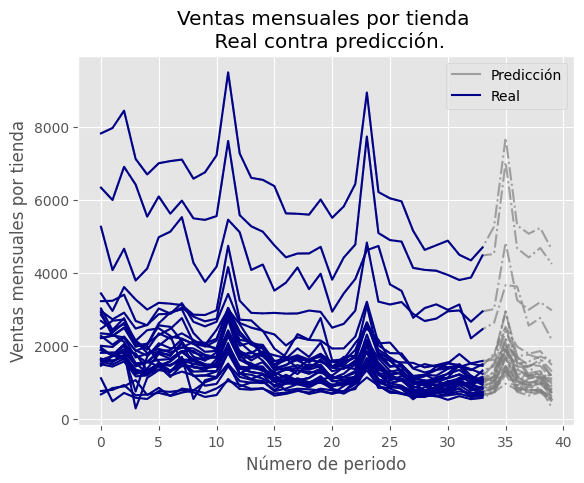

In [152]:
plt.title("Ventas mensuales por tienda \n Real contra predicción.")
for c in all.columns.tolist():
    plt.plot(all[c], alpha = 0.7, color = 'gray', linestyle = '-.')
plt.plot(all[c], alpha = 0.7, color = 'gray', label = 'Predicción')
plt.plot(sales_month_shop_train.reset_index().drop(columns = ['period']), color = 'darkblue')
plt.plot(sales_month_shop_train.reset_index().drop(columns = ['period'])[c], color = 'darkblue', label = 'Real')
plt.xlabel("Número de periodo")
plt.ylabel("Ventas mensuales por tienda")
plt.legend()

In [153]:
forecasts

,2,3,4,6,7,12,14,15,16,18,...,42,44,45,46,47,50,52,53,56,59
2015-11,743,726,686,1715,1237,1302,1047,1134,1014,1152,...,3006,818,741,1277,1793,932,916,970,1506,871
2015-12,1283,963,1366,2939,2197,1906,1436,1951,1872,1893,...,4824,1323,1213,2186,2522,1739,1649,1669,2018,1338
2016-01,917,796,899,1717,1428,1096,1018,1344,1374,1451,...,3251,763,737,1595,1978,1145,978,1148,1716,852
2016-02,725,704,866,1758,1411,1168,933,1202,1121,1452,...,2987,850,639,1171,1782,990,907,931,1213,782
2016-03,764,747,844,1652,1176,1136,952,1101,1135,1532,...,3194,987,721,1275,1856,1047,1004,1121,1219,799
2016-04,637,549,306,1298,811,1210,688,776,831,1159,...,2969,730,477,890,1471,709,720,707,775,530


In [169]:
sales_month_train

,period,year,month,shop_id,item_id,item_cnt_month,item_price_mavg
3920,2013-01,2013,01,2,27,1.0,2499.0
3921,2013-01,2013,01,2,33,1.0,499.0
3922,2013-01,2013,01,2,317,1.0,299.0
3923,2013-01,2013,01,2,438,1.0,299.0
3924,2013-01,2013,01,2,471,2.0,399.0
...,...,...,...,...,...,...,...
1608221,2015-10,2015,10,59,22087,6.0,119.0
1608222,2015-10,2015,10,59,22088,2.0,119.0
1608223,2015-10,2015,10,59,22091,1.0,179.0
1608224,2015-10,2015,10,59,22100,1.0,629.0


Obtenemos los Shares de ventas por item

In [183]:
last_month_sales = items_shops_catalog.merge(sales_month_train[sales_month_train.period == last_period][['shop_id', 'item_id', 'item_cnt_month']], 
    on = ['shop_id', 'item_id'], 
    how = 'left'
).fillna(0)

last_month_sales = last_month_sales.merge(
    last_month_sales.groupby("shop_id").sum()[['item_cnt_month']].reset_index().rename(columns = {'item_cnt_month':'month_sales'}), 
    on = 'shop_id', 
    how = 'left'
)

last_month_sales['item_share'] = last_month_sales['item_cnt_month']/last_month_sales['month_sales']

In [188]:
forecasts = forecasts.reset_index().rename(columns = {'index':'period'})

In [201]:
forecasts_melt = forecasts.melt(
    id_vars='period', 
    var_name = 'shop_id', 
    value_name= 'month_sales'
)

In [210]:
forecasts_items = last_month_sales[['shop_id', 'item_id', 'item_share']].merge(forecasts_melt, on = 'shop_id', how = 'left')

In [213]:
forecasts_items['item_cnt_month'] = (forecasts_items['month_sales']*forecasts_items['item_share']).round().astype("int")

Guardamos los forecasts

In [ ]:
#forecasts_items.to_csv()